## Disables abls warnings

In [2]:
import absl.logging
absl.logging.set_verbosity('error')

## Google Colab Stuff

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/Thesis")

ModuleNotFoundError: No module named 'google.colab'

## Training
> ! This will take a very long time if not parallized in multible notebooks

In [4]:
import jax
from models.disrnn_utils import create_disrnn_train_state, disrnn_value_trainstep
from models.gru_utils import create_gru_train_state, gru_value_trainstep
from models.rnn_utils import train_model
from custom_datasets import custom_collate, from_disk
from torch.utils.data import DataLoader
from itertools import product

import absl.logging
absl.logging.set_verbosity('error')

In [ ]:
SEQ_LENGTH = 1_000
OUT_DIM = 1
IN_DIM = 2

LEARNING_RATE = 0.001
BATCH_SIZE = 10
NUM_EPOCHS = 5
STOP_TRAINING = 5

VALUERNN_HIDDEN_SIZES = [20, 10, 5, 4, 3, 2]
DISRNN_HIDDEN_SIZES = [10]
DISRNN_KL_LOSSES = [0.01, 0.0075, 0.005]

OMISSON_PROBABILITIES = [0, 0.1]

# Value RNNs
for om_prob, hidden_size in product(OMISSON_PROBABILITIES, VALUERNN_HIDDEN_SIZES):
    om_prob_str = str(om_prob).replace('.', '')
    dataset = from_disk("MyStarkweather", f"data/belief_{om_prob_str}")
    train_dataloader = DataLoader(dataset,
                                  batch_size=10,
                                  drop_last=True,
                                  collate_fn=custom_collate)

    print("Training on Hidden Size: ", hidden_size)

    master_key = jax.random.PRNGKey(0)
    state = create_gru_train_state(master_key,
                                learning_rate=LEARNING_RATE,
                                hidden_size=hidden_size,
                                batch_size=BATCH_SIZE,
                                seq_length=SEQ_LENGTH,
                                out_dim=OUT_DIM,
                                in_dim=IN_DIM)

    save_path = f"data/models/belief_models/vrnn_{str(LEARNING_RATE).replace('.', '')}_{hidden_size}_{om_prob_str}"
    trained_model_state, training_metrics = train_model(state,
                                                        train_dataloader,
                                                        train_step_fun=gru_value_trainstep,
                                                        num_epochs=NUM_EPOCHS,
                                                        stop_training=STOP_TRAINING,
                                                        print_every_other=1,
                                                        save_path=save_path)
    del master_key

# DisRNNs
for om_prob, hidden_size, kl_loss in product(OMISSON_PROBABILITIES, DISRNN_HIDDEN_SIZES, DISRNN_KL_LOSSES):
    print(f"Training om_prob: {om_prob}, hidden_size: {hidden_size}, kl_loss: {kl_loss}")
    om_prob_str = str(om_prob).replace('.', '')
    dataset = from_disk("MyStarkweather", f"data/belief_{om_prob_str}")
    train_dataloader = DataLoader(dataset,
                                  batch_size=10,
                                  drop_last=True,
                                  collate_fn=custom_collate)

    master_key = jax.random.PRNGKey(0)
    state = create_disrnn_train_state(master_rng_key=master_key,
                                      learning_rate=LEARNING_RATE,
                                      hidden_size=hidden_size,
                                      batch_size=BATCH_SIZE,
                                      seq_length=SEQ_LENGTH,
                                      in_dim=IN_DIM,
                                      out_dim=OUT_DIM,
                                      update_mlp_shape=[5, 5, 5],
                                      choice_mlp_shape=[2, 2],
                                      kl_loss_factor=kl_loss,
                                      )

    save_path = f"data/models/belief_models/vrnn_{str(LEARNING_RATE).replace('.', '')}_{hidden_size}_{om_prob_str}_{str(kl_loss).replace('.','')}"
    trained_model_state, training_metrics = train_model(state,
                                                        train_dataloader,
                                                        train_step_fun=disrnn_value_trainstep,
                                                        num_epochs=NUM_EPOCHS,
                                                        stop_training=STOP_TRAINING,
                                                        print_every_other=1,
                                                        save_path=save_path)
    del master_key

## Analysis
> this may take a long time mainly due to the logistic decoder. The results after the execution are in the cell below

In [9]:
from belief_utils import decode_available_models, convert_to_mytrial, calc_rpe_groups, extract_last_vals
from custom_datasets import from_disk
from belief_analyze import multi_value_analyze2, plot_compare_rpes
import absl.logging
absl.logging.set_verbosity('error')

model_confs = decode_available_models()
trial_dict = multi_value_analyze2(0.0, model_confs)

Creating POMDP reference model...


/home/maexxel/dev/Thesis/belief_analyze.py:336: RuntimeWarning: Mean of empty slice
  values_normal[k] = np.nanmean(np.vstack(values_normal[k]), axis=0)


Analyzing models...
	Found model at path: vrnn_0001_4_0 with conf: type=vrnn, learning_rate=0.001, hidden_size=4, ommision_probs=0.0
		Model state loaded.
		Model probed.
		Added value and RPEs.
		Calculated models r2:  0.2301828030131957
	Found model at path: vrnn_0001_5_00 with conf: type=vrnn, learning_rate=0.001, hidden_size=5, ommision_probs=0.0
		Model state loaded.
		Model probed.
		Added value and RPEs.
		Calculated models r2:  0.29486783964564234
	Found model at path: disrnn_0001_5_00_00 with conf: type=disrnn, learning_rate=0.001, hidden_size=5, ommision_probs=0.0, kl_loss=0.0
		Model state loaded.
		Model probed.
		Added value and RPEs.
		Calculated models r2:  0.32061264210083595
	Found model at path: vrnn_0001_2_00 with conf: type=vrnn, learning_rate=0.001, hidden_size=2, ommision_probs=0.0
		Model state loaded.
		Model probed.
		Added value and RPEs.
		Calculated models r2:  0.06366185027375237
	Found model at path: vrnnuntrained_0001_50_00 with conf: type=vrnnuntrained, 

In [15]:
# Values from cell above

from belief_utils import decode_available_models
model_confs = decode_available_models()

trial_dict_om_prob_0 = {'vrnn_0001_4_0': {'MSE': 0.0008506220166934231,
  'll': -0.82003557263325,
  'r2_bias': 0.18740807818386995,
  'r2': 0.2301828030131957},
 'vrnn_0001_5_00': {'MSE': 0.0005907215268996553,
  'll': -0.9111681789459964,
  'r2_bias': 0.2580701262093277,
  'r2': 0.29486783964564234},
 'disrnn_0001_5_00_00': {'MSE': 0.0006717797653260158,
  'll': -0.2811314901573182,
  'r2_bias': 0.2875622518884646,
  'r2': 0.32061264210083595},
 'vrnn_0001_2_00': {'MSE': 0.0010859031393543816,
  'll': -1.6619166120409783,
  'r2_bias': -0.0009023582858975754,
  'r2': 0.06366185027375237},
 'disrnn_0001_10_00_0000001': {'MSE': 0.0004586558799172826,
  'll': -0.527803558639025,
  'r2_bias': 0.251704590184644,
  'r2': 0.2873207039736102},
 'vrnnuntrained_0001_5_00': {'MSE': 0.02463249645767522,
  'll': -1.4541135547351876,
  'r2_bias': 0.35157374224806104,
  'r2': 0.1433025783410421},
 'vrnn_0001_3_0': {'MSE': 0.0006851707401202363,
  'll': -1.0286387703584907,
  'r2_bias': 0.011723995211035065,
  'r2': 0.07683026488566402},
 'vrnn_0001_20_00': {'MSE': 0.0002317453214036967,
  'll': -0.6662538286714889,
  'r2_bias': 0.48162149461993753,
  'r2': 0.5060240428614984},
 'disrnn_0001_10_00_000001': {'MSE': 0.0006889466141318067,
  'll': -0.8549665771923526,
  'r2_bias': 0.18347001203717395,
  'r2': 0.22747707730874067},
 'vrnn_0001_50_00': {'MSE': 0.0001474547640010234,
  'll': -0.5135436438021501,
  'r2_bias': 0.5322912285246142,
  'r2': 0.5538223845028256},
 'disrnn_0001_2_00_00': {'MSE': 0.0019815096989366228,
  'll': -0.7186924235604683,
  'r2_bias': 0.011954918250886015,
  'r2': 0.07491991083313232},
 'disrnn_0001_10_00_00': {'MSE': 0.0007247209065700577,
  'll': -0.18126966721167506,
  'r2_bias': 0.40723887269313885,
  'r2': 0.43443767578123316},
 'disrnn_0001_10_00_00001': {'MSE': 0.005852308100868523,
  'll': -2.0008268082368486,
  'r2_bias': -0.016957881269275443,
  'r2': 0.0699418118533176},
 'vrnn_0001_10_00': {'MSE': 0.00035239550911722367,
  'll': -0.8633915978668959,
  'r2_bias': 0.3662321090759244,
  'r2': 0.39667437431862174},
 'vrnnuntrained_0001_50_00': {'MSE': 0.004124660491930584,
  'll': -0.7700333057188136,
  'r2_bias': 0.5523849815594578,
  'r2': 0.39481107150367556},
 'vrnnuntrained_0001_20_00': {'MSE': 0.006182031705808157,
  'll': -0.9150888919131757,
  'r2_bias': 0.5000113879584109,
  'r2': 0.3231760584093485},
 'vrnnuntrained_0001_10_00': {'MSE': 0.008485292632531994,
  'll': -1.196646553354794,
  'r2_bias': 0.4601324463343376,
  'r2': 0.2611714519201884}}

trial_dict_om_prob_1 = {'vrnn_0001_10_01': {'MSE': 0.0006074859495137518,
  'll': -0.8326054268407621,
  'r2_bias': 0.4634387095945519,
  'r2': 0.4434015988989374},
 'vrnn_0001_3_01': {'MSE': 0.002384548376438564,
  'll': -1.2405217962459176,
  'r2_bias': 0.21522510986002585,
  'r2': 0.1560778584095759},
 'disrnn_0001_2_01_00': {'MSE': 0.0024238969929963414,
  'll': -1.6451139357192406,
  'r2_bias': 0.14753714793687034,
  'r2': 0.12132767486283824},
 'disrnn_0001_10_01_0000001': {'MSE': 0.0013227323429034319,
  'll': -1.0230815205896189,
  'r2_bias': 0.28956299208731184,
  'r2': 0.28577846128797724},
 'vrnn_0001_5_01': {'MSE': 0.0008579780010996715,
  'll': -1.1673758724009087,
  'r2_bias': 0.381209284974264,
  'r2': 0.3385636299925079},
 'vrnnuntrained_0001_5_01': {'MSE': 0.016200469280724158,
  'll': -1.414619811838635,
  'r2_bias': 0.40878923611271056,
  'r2': 0.13153077334865804},
 'vrnn_0001_20_01': {'MSE': 0.0003227468276138112,
  'll': -0.6253839157854875,
  'r2_bias': 0.5139628187787446,
  'r2': 0.5114693635302734},
 'vrnn_0001_2_01': {'MSE': 0.0012022830679193906,
  'll': -1.7835244531880348,
  'r2_bias': 0.22569499640545132,
  'r2': 0.07952674002338156},
 'disrnn_0001_10_01_00001': {'MSE': 0.004784870057048308,
  'll': -2.311481405733066,
  'r2_bias': 0.13857204334996376,
  'r2': 0.06773129371537201},
 'vrnn_0001_50_01': {'MSE': 0.00039989310647181125,
  'll': -0.5201414158785572,
  'r2_bias': 0.5796753862264057,
  'r2': 0.579263128389479},
 'disrnn_0001_10_01_000001': {'MSE': 0.0015666370921829482,
  'll': -1.314024990795467,
  'r2_bias': 0.24116761225908512,
  'r2': 0.18339761105706276},
 'vrnn_0001_4_01': {'MSE': 0.0022695605746781283,
  'll': -1.3787583524397948,
  'r2_bias': 0.2193719877259972,
  'r2': 0.19936374785770872},
 'disrnn_0001_5_01_00': {'MSE': 0.0013716636457983323,
  'll': -0.7510418830687696,
  'r2_bias': 0.37662463938888724,
  'r2': 0.318726056475501},
 'disrnn_0001_10_01_00': {'MSE': 0.0006317901535934728,
  'll': -0.44018799552628535,
  'r2_bias': 0.4798726403407887,
  'r2': 0.46225525812621726},
 'vrnnuntrained_0001_20_01': {'MSE': 0.0037680626997867593,
  'r2_bias': 0.5438886434610457,
  'll': -1.0044177818940057,
  'r2': 0.2909206503498507},
 'vrnnuntrained_0001_50_01': {'MSE': 0.0023683989146913555,
  'r2_bias': 0.5925479971921148,
  'll': -0.8571871514924191,
  'r2': 0.3552847321547834},
 'vrnnuntrained_0001_10_01': {'MSE': 0.005239354164989345,
  'r2_bias': 0.5073643499660606,
  'll': -1.2589475288993233,
  'r2': 0.23314971195126066}}

### Main Plots

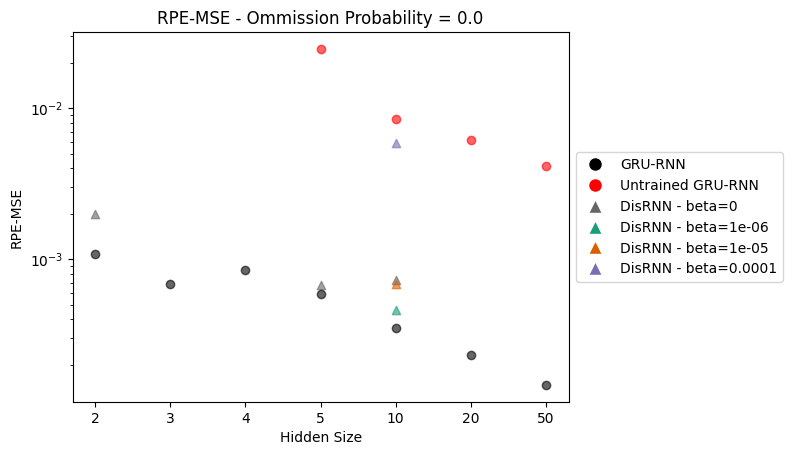

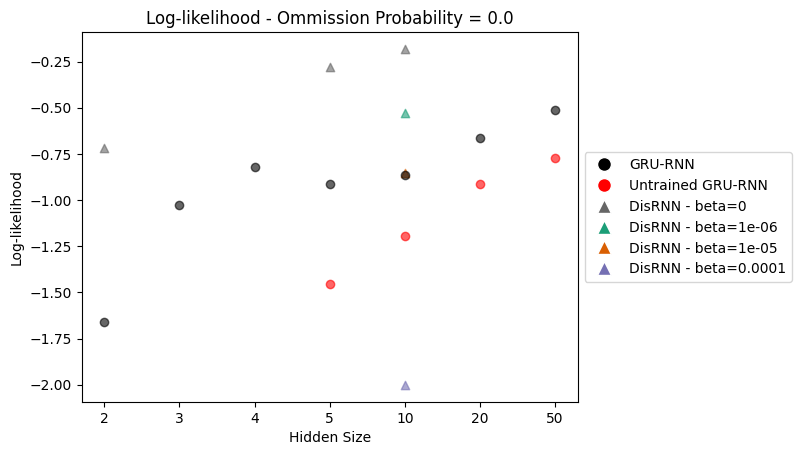

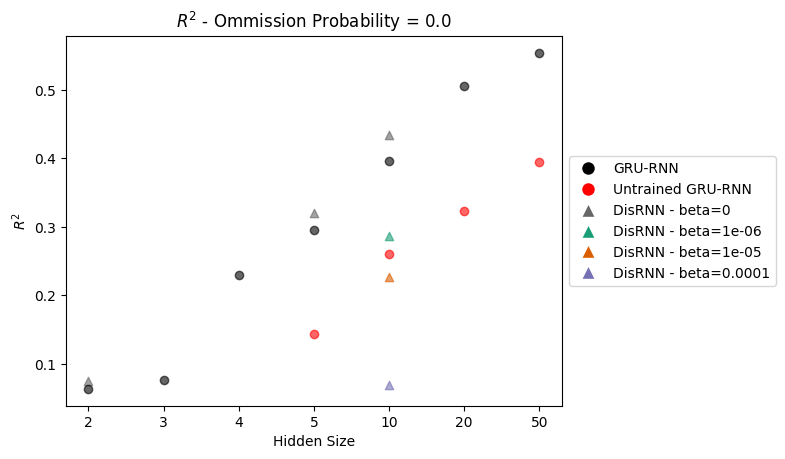

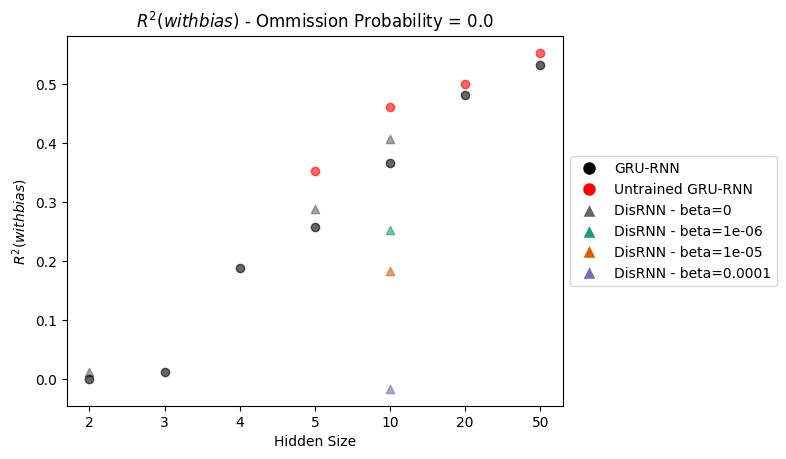

In [16]:
from belief_analyze import plot_mses
plot_mses({model_name: key["MSE"] for model_name, key in trial_dict_om_prob_0.items()},
          model_confs, "RPE-MSE")
plot_mses({model_name: key["ll"] for model_name, key in trial_dict_om_prob_0.items()},
          model_confs, "Log-likelihood")
plot_mses({model_name: key["r2"] for model_name, key in trial_dict_om_prob_0.items()},
          model_confs, "$R^2$")
plot_mses({model_name: key["r2_bias"] for model_name, key in trial_dict_om_prob_0.items()},
          model_confs, "$R^2 (with bias)$")

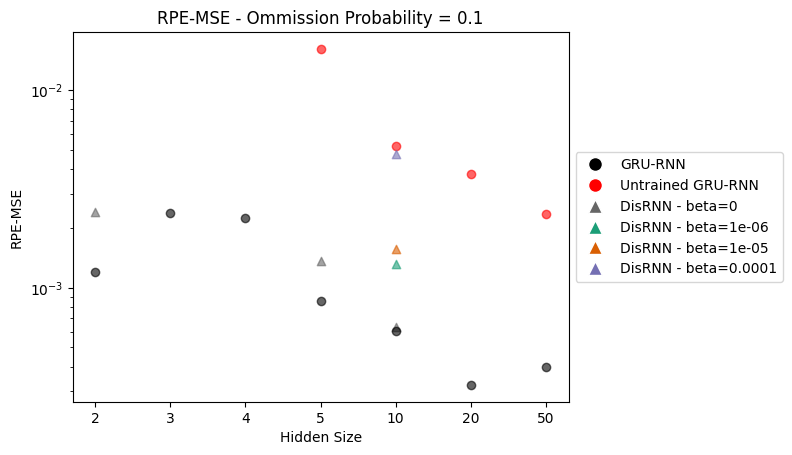

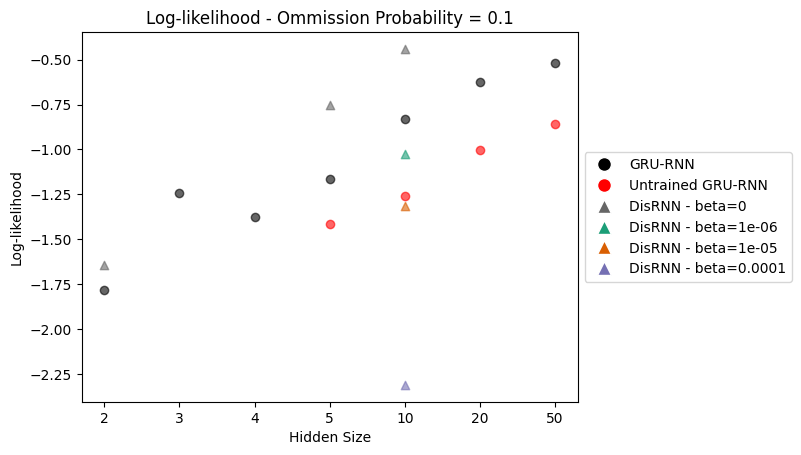

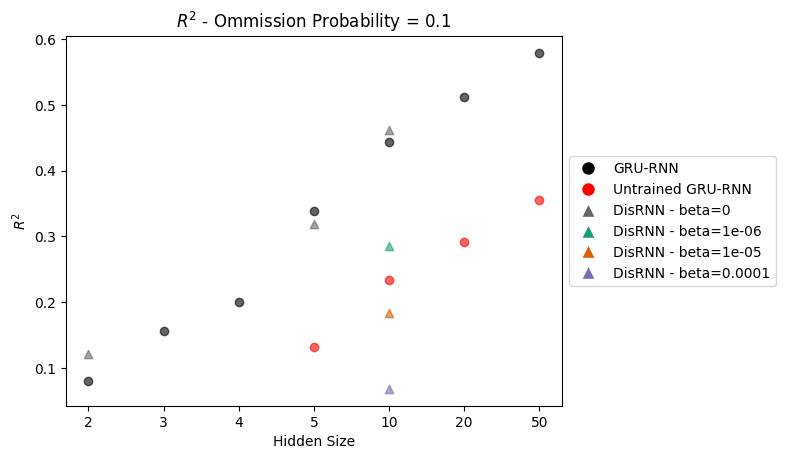

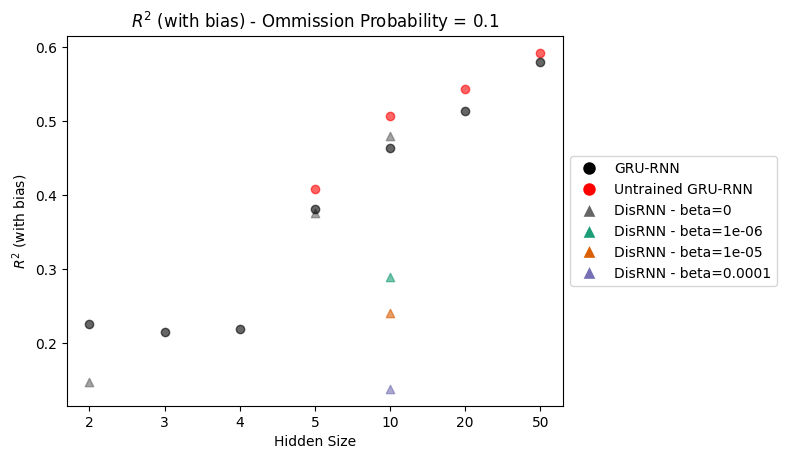

In [8]:
from belief_analyze import plot_mses
plot_mses({model_name: key["MSE"] for model_name, key in trial_dict_om_prob_1.items()},
          model_confs, "RPE-MSE")
plot_mses({model_name: key["ll"] for model_name, key in trial_dict_om_prob_1.items()},
          model_confs, "Log-likelihood")
plot_mses({model_name: key["r2"] for model_name, key in trial_dict_om_prob_1.items()},
          model_confs, "$R^2$")
plot_mses({model_name: key["r2_bias"] for model_name, key in trial_dict_om_prob_1.items()},
          model_confs, "$R^2$ (with bias)")

### RPE-Curves (not used in the final version)

Creating POMDP reference model...
Analyzing models...
	Found model at path: vrnn_0001_5_01 with conf: type=vrnn, learning_rate=0.001, hidden_size=5, ommision_probs=0.1
		Model state loaded.
		Model probed.
		Added value and RPE converted to MyTrial.
	Found model at path: disrnn_0001_10_01_00 with conf: type=disrnn, learning_rate=0.001, hidden_size=10, ommision_probs=0.1, kl_loss=0.0
		Model state loaded.
		Model probed.
		Added value and RPE converted to MyTrial.
	Found model at path: vrnnuntrained_0001_5_01 with conf: type=vrnnuntrained, learning_rate=0.001, hidden_size=5, ommision_probs=0.1
		Model state loaded.
		Model probed.
		Added value and RPE converted to MyTrial.


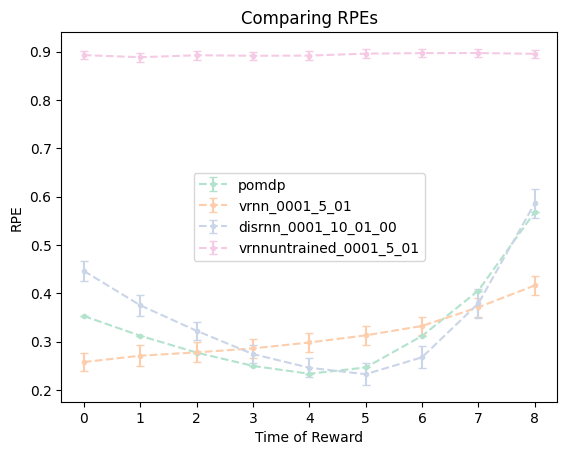

In [14]:
from belief_analyze import plot_compare_rpes, multi_value_analyze
from belief_utils import extract_last_vals, calc_rpe_groups, decode_available_models

model_confs = decode_available_models()
temp = {"vrnn_0001_5_01": model_confs["vrnn_0001_5_01"],
        "disrnn_0001_10_01_00": model_confs["disrnn_0001_10_01_00"],
        "vrnnuntrained_0001_5_01": model_confs["vrnnuntrained_0001_5_01"]}
trial_dict = multi_value_analyze(0.1, temp)

rpegroup_dict = {}
for key, value in trial_dict.items():
    rpegroup_dict[key] = calc_rpe_groups(value)
    
plot_compare_rpes(extract_last_vals(rpegroup_dict))

### Bottleneck plots of selected networks

In [ ]:
from models.rnn_utils import load_model_state
from models.disrnn_analysis import plot_bottlenecks
import matplotlib.pyplot as plt

state = load_model_state("data/models/belief_models/disrnn_0001_10_01_00001")
final_bottlenecks1 = plot_bottlenecks(state["params"],
                                     title=r"DisRNN - ${\beta}=1\times 10^{-4}$, $p_o=0.1$")

state = load_model_state("data/models/belief_models/disrnn_0001_10_00_00001")
final_bottlenecks2 = plot_bottlenecks(state["params"],
                                     title=r"DisRNN - ${\beta}=1\times 10^{-4}$, $p_o=0.0$")

state = load_model_state("data/models/belief_models/disrnn_0001_2_01_00")
final_bottlenecks3 = plot_bottlenecks(state["params"],
                                     title=r"DisRNN - ${\beta}=0$,$\text{hidden-size}=2$, $p_o=0.1$")

state = load_model_state("data/models/belief_models/disrnn_0001_10_00_000001")
final_bottlenecks = plot_bottlenecks(state["params"],
                                     title=r"DisRNN - ${\beta}=1\times 10^{-5}$, $p_o=0$")
state = load_model_state("data/models/belief_models/disrnn_0001_10_01_000001")
final_bottlenecks = plot_bottlenecks(state["params"],
                                     title=r"DisRNN - ${\beta}=1\times 10^{-5}$, $p_o=0.1$")